# Improved georeferencing through higher quality pose information

In this notebook we show how the final projected and georeferenced raster from our `georeference()` function can be improved with a higher quality input yaw and pitch. We do this with a gimbal that records higher accuracy pose information.

Our process is simple, first we grab the processed Rrs imagery and metadata, then we pull in the .csv of higher accuracy yaw and pitch, and then we use this to do the georeferencing.

Pull in all the modules needed for this code.

In [2]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils import *
# from georeg import *

import random
import cameratransform as ct
from rasterio.merge import merge

ModuleNotFoundError: No module named 'geopandas'

In [9]:
# this isn't really good practice but there are a few deprecated tools in the Micasense stack so we'll ignore some of these warnings
import warnings
warnings.filterwarnings('ignore')

We'll use a dataset that is already processed, simply the output of the `process_raw_to_rrs()` function with the addition of a .csv file output from the gimbal.

In [1]:
project_path = 'improved_georef_dataset/'
project_path

'improved_georef_dataset/'

Pull in the imagery and metadata

## View metadata 

Metadata is the same for each processed dataset

In [20]:
rrs_img_metadata.head()

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time
filename,,,,,,,,,,,,,,,
capture_1.tif,gulf_stream_dataset/capture_1.tif,2021:08:27,13:40:21,35.681063,N,-74.715423,W,46.819,7.783703,2064,1544,-84.804200,-7.051282,-2.650998,2021-08-27 13:40:21
capture_2.tif,gulf_stream_dataset/capture_2.tif,2021:08:27,13:40:24,35.681064,N,-74.715423,W,50.670,7.783703,2064,1544,-85.071254,-6.821101,-2.438832,2021-08-27 13:40:24
capture_3.tif,gulf_stream_dataset/capture_3.tif,2021:08:27,13:40:26,35.681064,N,-74.715424,W,54.198,7.783703,2064,1544,-85.090709,-6.993140,-2.478809,2021-08-27 13:40:26
capture_4.tif,gulf_stream_dataset/capture_4.tif,2021:08:27,13:40:28,35.681065,N,-74.715424,W,57.719,7.783703,2064,1544,-88.604540,-7.375491,-1.867958,2021-08-27 13:40:28
capture_5.tif,gulf_stream_dataset/capture_5.tif,2021:08:27,13:40:30,35.681066,N,-74.715425,W,60.846,7.783703,2064,1544,-94.504489,-7.149540,-1.972097,2021-08-27 13:40:30


### Georeferencing 


We have included code that allow the user to georeference an image based entirely on the drone sensor yaw, pitch, roll, lat, lon, and altitude. While this can be inaccurate if the yaw, pitch, and roll information is imprecise, it is the best option given that structure from motion algorithms don't work in most aquatic environments. With highly accurate pose and geolocation information this can lead to great results and even be mosaicked.

In [41]:
def format_alta_logs(fp):
    alta_logs = pd.read_csv(fp)
    # the last few hundred lines don't follow csv rules and are just summary data
    alta_logs.drop(alta_logs.tail(250).index,inplace=True)
    # this may introduce a tiny bit of error but I do this so I have a unique index for matching time
    # TODO could instead resample to seconds and take a mean
    alta_logs['id'] = alta_logs.index
    alta_logs['dt'] = pd.to_datetime(alta_logs.Date.apply(str)+alta_logs['GPS Time']+'.'+alta_logs.id.apply(str).str.zfill(9).apply(str).str.slice(start=3,stop=9), format='%Y%m%d%H:%M:%S.%f')
    alta_logs = alta_logs.set_index('dt')
    alta_logs = alta_logs.sort_index()
    return(alta_logs)

In [42]:
alta_logs = format_alta_logs(project_path + '/SYNLog-13-39-33_27-08-2021_edit.csv')
alta_logs.head()

,Reading,IMU Time,Date,GPS Time,Unnamed: 4,Longitude,Latitude,GPS Height,GPS Course,GPS Pos N,...,Gyro Bias P,Gyro Bias Y,Accel Bias X,Accel Bias Y,Accel Bias Z,Extended Status,5V Alarm,Z Vibration,Checksum,id
dt,,,,,,,,,,,,,,,,,,,,,
2021-08-27 13:39:34.000000,46,1.766,20210827,13:39:34,NaN,-747154560,356808608,2.92,4.3,183.02,...,-37.2736,8.8494,0.148,0.135,0.237,0,0,0.07,23,0
2021-08-27 13:39:34.000001,47,1.806,20210827,13:39:34,NaN,-747154560,356808608,2.92,4.3,183.02,...,-37.2708,8.8476,0.149,0.136,0.237,0,0,0.07,118,1
2021-08-27 13:39:34.000002,48,1.846,20210827,13:39:34,NaN,-747154560,356808608,2.92,4.3,183.02,...,-37.2703,8.8488,0.150,0.137,0.237,0,0,0.07,37,2
2021-08-27 13:39:34.000003,49,1.886,20210827,13:39:34,NaN,-747154560,356808608,2.92,4.3,183.02,...,-37.2672,8.8489,0.151,0.137,0.237,0,0,0.07,131,3
2021-08-27 13:39:34.000004,50,1.926,20210827,13:39:34,NaN,-747154496,356808608,2.91,4.2,183.02,...,-37.2624,8.8453,0.153,0.138,0.236,0,0,0.07,190,4


In [44]:
alta_yaws = []
for index, row in rrs_img_metadata.iterrows(): # yes I know this is an anti-pattern
    # utc_time = datetime.datetime.strptime(row['UTC-Time'], '%Y-%m-%d-%H:%M:%S')
    img_idx = alta_logs.index.get_loc(row['UTC-Time'], method='nearest')
    alta_yaws.append((alta_logs.iloc[img_idx]['Yaw'] + 360) % 360)

In [45]:
rrs_img_metadata['alta_yaw'] = alta_yaws

Then we can compare the output just from a single image where we have a known feature, in this case a sea wall.

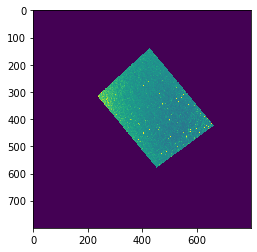

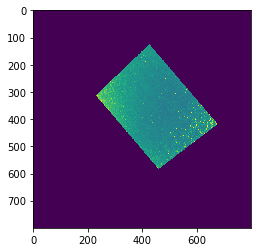

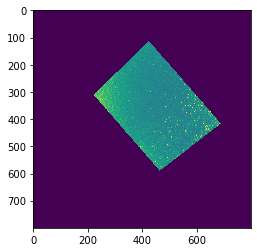

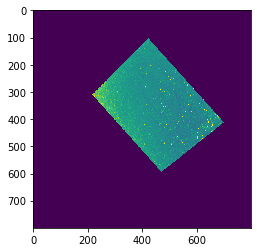

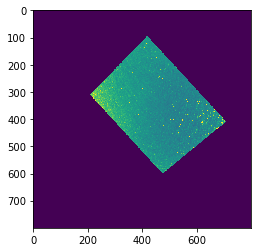

True

In [38]:
georeference(main_dir=project_path, img_dir=project_path+'/rrs_mobley', output_dir_name='georeferenced_rrs_mobley', 
             flip=False, plot=True, start=10,
            count = 5, yaw='alta_yaw')

(5, 801, 802)


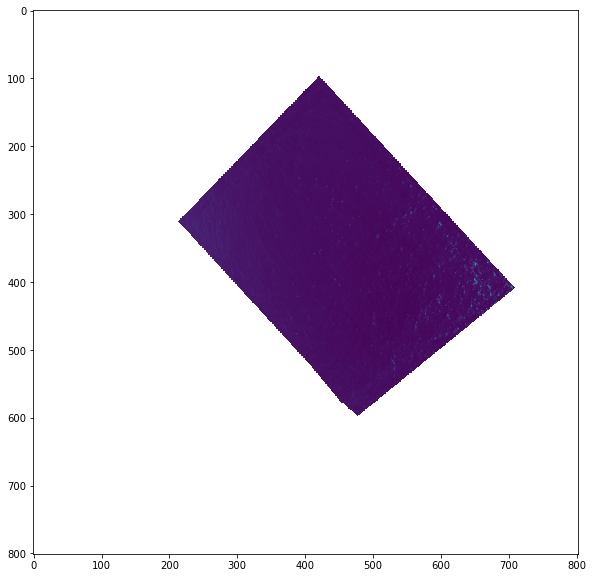

In [39]:
foo = mosaic(main_dir=project_path, img_dir = project_path+'/georeferenced_rrs_mobley', output_name='mosaic', plot=True, save=True, band_to_plot=0)
print(foo.shape)

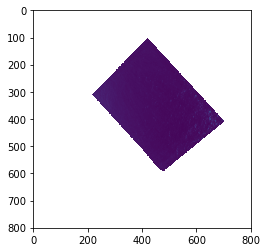

In [40]:
plt.imshow(foo[0,:,:])

#### Trying to figure out plotting points/.tifs over basemap

In [47]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(4, 4))

m = Basemap(projection='lcc', resolution='c',
            width=100000, height=100000, 
            lat_0=41, lon_0=-83, epsg=4326)

#m.etopo(scale=0.5, alpha=0.5)
plt.scatter(rrs_img_metadata['    GPSLongitude'], rrs_img_metadata['    GPSLatitude'])

plt.show()

In [38]:
rrs_imgs_hedley_masked, rrs_img_metadata = retrieve_imgs_and_metadata(img_dir = project_path+'/masked_rrs_hedley')
rrs_img_metadata


,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time
filename,,,,,,,,,,,,,,,
capture_1.tif,../../../Broadford_Lake/0000SET/test/capture_1...,2022:09:09,14:31:26,39.413735,N,-79.372333,W,830.910,5.43432,1280,960,-104.755043,10.051656,-10.353182,2022-12-09 14:31:26
capture_2.tif,../../../Broadford_Lake/0000SET/test/capture_2...,2022:09:09,14:31:28,39.413739,N,-79.372136,W,831.069,5.43432,1280,960,-102.999767,5.262329,-9.868161,2022-12-09 14:31:28
capture_3.tif,../../../Broadford_Lake/0000SET/test/capture_3...,2022:09:09,14:31:29,39.413743,N,-79.372006,W,831.183,5.43432,1280,960,-102.912107,12.716979,-9.874853,2022-12-09 14:31:29
capture_4.tif,../../../Broadford_Lake/0000SET/test/capture_4...,2022:09:09,14:31:30,39.413752,N,-79.371824,W,831.106,5.43432,1280,960,-102.934161,15.560780,-11.840869,2022-12-09 14:31:30
capture_5.tif,../../../Broadford_Lake/0000SET/test/capture_5...,2022:09:09,14:31:32,39.413766,N,-79.371603,W,830.867,5.43432,1280,960,-103.214419,12.266589,-16.332490,2022-12-09 14:31:32
capture_6.tif,../../../Broadford_Lake/0000SET/test/capture_6...,2022:09:09,14:31:33,39.413775,N,-79.371407,W,830.749,5.43432,1280,960,-102.863699,10.280256,-16.620142,2022-12-09 14:31:33


In [43]:
import geopandas

# Create point geometries
geometry = geopandas.points_from_xy(rrs_img_metadata['GPSLongitude'], rrs_img_metadata['GPSLatitude'])
geo_df = geopandas.GeoDataFrame(
    rrs_img_metadata, geometry=geometry
)

geo_df.head()

,SourceFile,GPSDateStamp,GPSTimeStamp,GPSLatitude,GPSLatitudeRef,GPSLongitude,GPSLongitudeRef,GPSAltitude,FocalLength,ImageWidth,ImageHeight,GPSImgDirection,GPSPitch,GPSRoll,UTC-Time,geometry
filename,,,,,,,,,,,,,,,,
capture_1.tif,../../../Broadford_Lake/0000SET/test/capture_1...,2022:09:09,14:31:26,39.413735,N,-79.372333,W,830.910,5.43432,1280,960,-104.755043,10.051656,-10.353182,2022-12-09 14:31:26,POINT (-79.37233 39.41373)
capture_2.tif,../../../Broadford_Lake/0000SET/test/capture_2...,2022:09:09,14:31:28,39.413739,N,-79.372136,W,831.069,5.43432,1280,960,-102.999767,5.262329,-9.868161,2022-12-09 14:31:28,POINT (-79.37214 39.41374)
capture_3.tif,../../../Broadford_Lake/0000SET/test/capture_3...,2022:09:09,14:31:29,39.413743,N,-79.372006,W,831.183,5.43432,1280,960,-102.912107,12.716979,-9.874853,2022-12-09 14:31:29,POINT (-79.37201 39.41374)
capture_4.tif,../../../Broadford_Lake/0000SET/test/capture_4...,2022:09:09,14:31:30,39.413752,N,-79.371824,W,831.106,5.43432,1280,960,-102.934161,15.560780,-11.840869,2022-12-09 14:31:30,POINT (-79.37182 39.41375)
capture_5.tif,../../../Broadford_Lake/0000SET/test/capture_5...,2022:09:09,14:31:32,39.413766,N,-79.371603,W,830.867,5.43432,1280,960,-103.214419,12.266589,-16.332490,2022-12-09 14:31:32,POINT (-79.37160 39.41377)


In [2]:
import folium

m = folium.Map(location=[39.4151, -79.3712], 
               tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
               attr= 'ESRI', zoom_start=15)


folium.raster_layers.ImageOverlay(
    image=foo[0,:,:],
    bounds=[[39, -79], [39, -79]],
    colormap=lambda x: (1, 0, 0, x),
).add_to(m)

m

ModuleNotFoundError: No module named 'folium'

AttributeError: 'Map' object has no attribute 'plot'

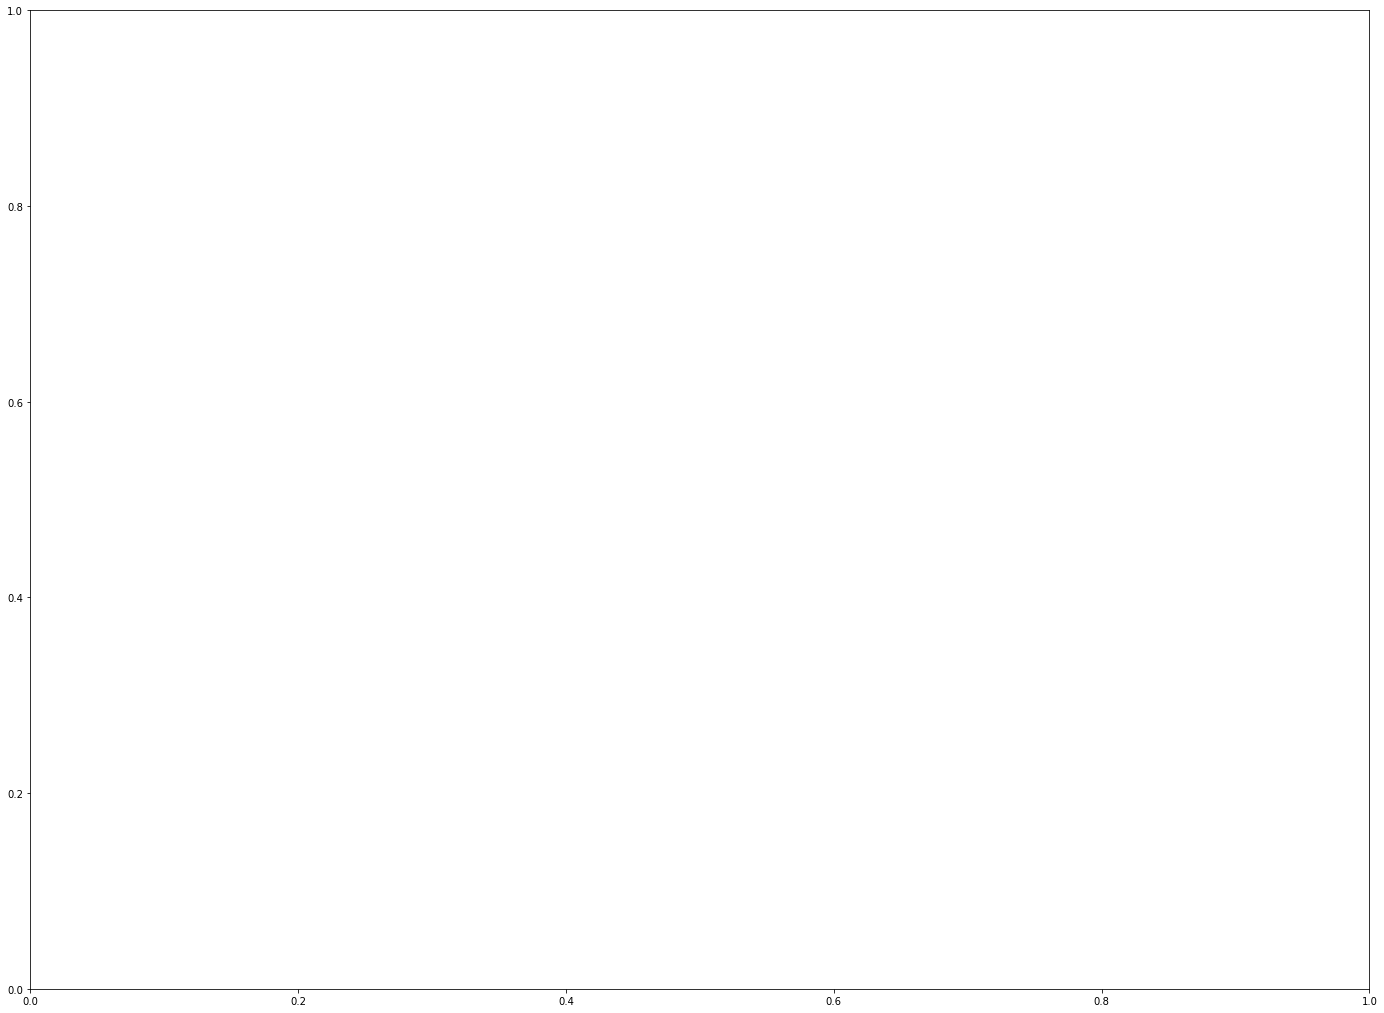

In [44]:
fig, ax = plt.subplots(figsize=(24, 18))
m.plot(ax=ax, alpha=0.4, color="grey")
geo_df.scatter(rrs_img_metadata.geometry, ax=ax, legend=True)
plt.title("Volcanoes")